In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os
import gcm_filters

In [2]:
eta = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta.zarr')

#eta_merged = eta_merged.isel(time=slice(1,110))

#eta_merged = eta_merged.drop_vars('time')

In [4]:
eta

<xarray.Dataset>
Dimensions:  (i: 2160, j: 2160, time: 420)
Coordinates:
    face     int64 ...
  * i        (i) int64 1080 1081 1082 1083 1084 ... 3235 3236 3237 3238 3239
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j        (j) float64 0.0 1.0 2.0 3.0 ... 2.157e+03 2.158e+03 2.159e+03
  * time     (time) timedelta64[ns] NaT 3 days 00:00:00 ... 20 days 10:00:00
    x        (j, i) float32 dask.array<chunksize=(270, 540), meta=np.ndarray>
    y        (j, i) float32 dask.array<chunksize=(270, 540), meta=np.ndarray>
Data variables:
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 270, 540), meta=np.ndarray>

In [3]:
wet_mask=xr.ones_like(eta)
wet_mask=wet_mask.where(eta!=0,0)


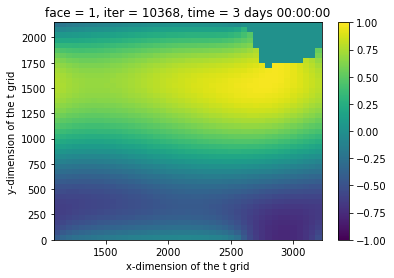

In [46]:
cor_fac = 50
eta_coarsened = eta.coarsen(i=cor_fac, j=cor_fac, boundary="trim").mean(keep_attrs=True)
wet_mask_coarsen = wet_mask.coarsen(i=cor_fac, j=cor_fac, boundary="trim").max(keep_attrs=True)

filter = gcm_filters.Filter(
    filter_scale=20,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask_coarsen}
)
filter
eta_filtered = filter.apply(eta_coarsened, dims=['i', 'j'])
eta_filtered.plot(x='i',vmin=-1,vmax=1)

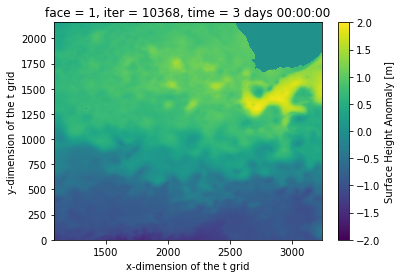

In [44]:
eta.plot(x='i',vmin=-2,vmax=2)

In [12]:
eta_coarsened.j

<xarray.DataArray 'i' (i: 540)>
array([1081.5, 1085.5, 1089.5, ..., 3229.5, 3233.5, 3237.5])
Coordinates:
    face     int64 1
  * i        (i) float64 1.082e+03 1.086e+03 1.09e+03 ... 3.234e+03 3.238e+03
    iter     int64 10368
    time     timedelta64[ns] 3 days
Attributes:
    axis:           X
    long_name:      x-dimension of the t grid
    standard_name:  x_grid_index
    swap_dim:       XC

In [ ]:
outdir='/swot/SUM03/spencer/swot_trimmed/'
for i in range(0,5):
    if np.mod(i,10)==0:
        print(i)
    nt = 10368 + i*144
    Nt = nt - 10368
    ds = xr.open_dataset(indir + 'llc_4320_agulhas.%010d.nc' %nt)
    theta = ds.Theta[0].isel(k=slice(0,30)).values
    salt = ds.Salt[0].isel(k=slice(0,30)).values
    eta = ds.Eta[0].values
    uvel = ds.U[0].isel(k=slice(0,30)).values
    vvel = ds.V[0].isel(k=slice(0,30)).values
    #output_binary_file(theta, os.path.join(outdir, 'theta.%010d.data' % Nt))
    #output_binary_file(salt, os.path.join(outdir, 'salt.%010d.data' % Nt))
    #output_binary_file(eta, os.path.join(outdir, 'eta.%010d.data' % Nt))
    #output_binary_file(uvel, os.path.join(outdir, 'uvel.%010d.data' % Nt))
    #output_binary_file(vvel, os.path.join(outdir, 'vvel.%010d.data' % Nt))
    ds.close()